# Compute correlations and integral lengthscale

### Definition

The two point correlation $R_{ij}$ is defined as
$$ R_{ij}({\mathbf x},\boldsymbol{\xi}) = 
\frac{\langle {u'_i(\mathbf{x}, t) u'_j(\mathbf{x}+\boldsymbol{\xi},t)} \rangle}
{ \sqrt{\langle u'^2_i \rangle} \sqrt{\langle u'^2_j \rangle}} $$

The fluctuations
$$ u'_i(\mathbf{x},t) = u_i(\mathbf{x},t) - \langle u_i(\mathbf{x},t) \rangle $$

The lengthscale is calculated as
$$ L = \int_0^\infty R_{ij}(\xi)\: {\textrm d}\xi  $$

See https://spiral.imperial.ac.uk/bitstream/10044/1/41599/4/Airflow_v16a_Revised25_final_deposit.pdf as a reference

In [27]:
# Add any possible locations of amr-wind-frontend here
amrwindfedirs = ['/projects/wind_uq/lcheung/amrwind-frontend/',
                 '/ccs/proj/cfd162/lcheung/amrwind-frontend/']
import sys, os, shutil
for x in amrwindfedirs: sys.path.insert(1, x)
for x in amrwindfedirs: sys.path.insert(1, x+'/utilities')    

import postproamrwindsample_xarray as ppsamplexr
import correlate as corr
import numpy as np
import matplotlib.pyplot as plt

In [28]:
amrdir = '/lustre/orion/proj-shared/cfd162/prakash/neutral_spectra_postprocessing/'
ncfile = 'XYdomain_090_240000.nc'  # netcdf filename

In [29]:
timerange=[120000.0, 125000] #[25000, 25300]   # Average between these times
iplane=0
group='Farm_XYdomain090'

In [30]:
avgdat, headers = corr.avgNCplaneXR(amrdir+'/'+ncfile, timerange, group, iplane, verbose=True)

/lustre/orion/proj-shared/cfd162/prakash/neutral_spectra_postprocessing//XYdomain_090_240000.nc 10001
[============================================================] 100.0% 
Ncount = 10001



In [31]:
corr.getsizesindices(avgdat, headers)

(513, 513, 1, [6, 7, 8])

In [32]:
iplane2=0
ij   = [0,0]
ws, winddir           = corr.getavgwind(avgdat, headers, iplane2)
print('WS   = '+repr(ws))
print('Wdir = '+repr(winddir))

WS   = [4.193443334621806, 1.3057661840144714, 5.866630775689277e-07]
Wdir = 252.70430911957942


In [33]:
# Create the probe list for LONGITUDINAL
# Set parameters
winddir= 270
if (winddir>270): s=-1
else:             s=+1
ds = 10
startx = np.arange(100,200,ds)
starty = np.arange(100,200,ds)[::s]
probelength = 1000 # Probe length should be a few hundred meters
startp = []
yoffset=0
[[startp.append([x,y+yoffset*iy,iplane2]) for x in startx] for iy, y in enumerate(starty)]

plistLONG = corr.makeprobeline(startp, winddir, probelength, avgdat)

Nlong      = len(plistLONG)
print("Len(plist)=%i"%Nlong)

Len(plist)=100


In [36]:
# Create the probe list for LATERAL
# Set parameters
winddir= 180
if (winddir>270): s=-1
else:             s=+1
#ds = 10
#startx = np.arange(200,300,ds)
#starty = np.arange(100,200,ds)[::s]
#probelength = 4000 # Probe length should may be 0.5*domain length
startp = []
yoffset=0
[[startp.append([x,y+yoffset*iy,iplane2]) for x in startx] for iy, y in enumerate(starty)]

plistLAT = corr.makeprobeline(startp, winddir, probelength, avgdat)

Nlat     = len(plistLAT)
print("Len(plist)=%i"%Nlat)

Len(plist)=100


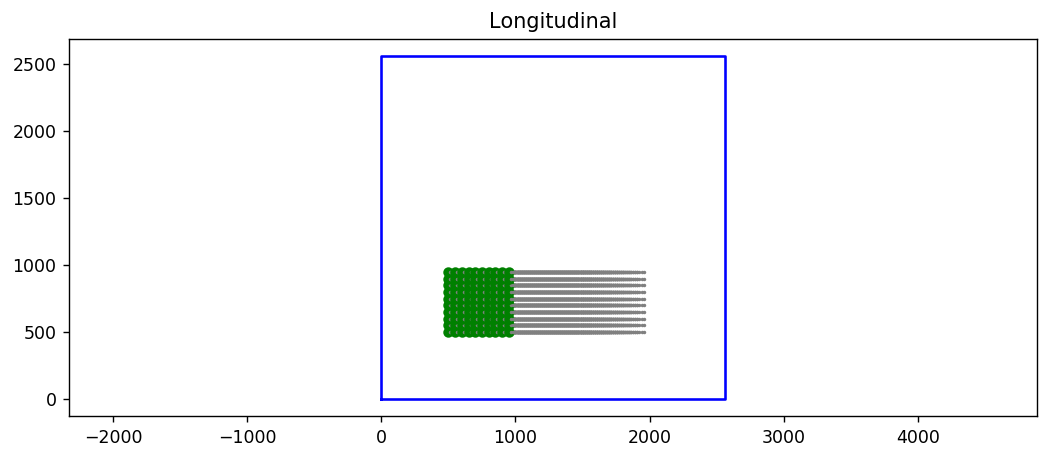

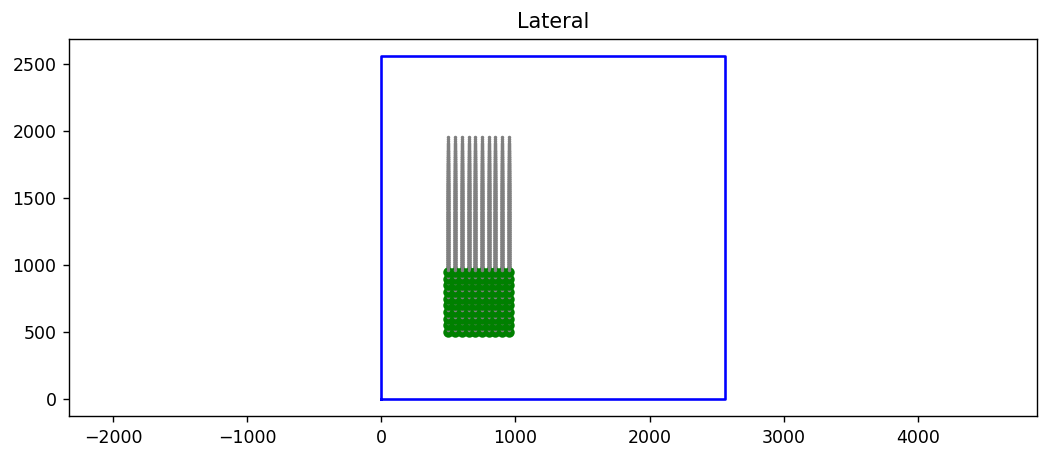

In [37]:
plotprobept = True
# Plot the probe points
if plotprobept:
    #avgdat, headers       = corr.loadavg(ncfilename, loadfromplanes, avgsavefile, verbose=True)
    # LONG
    plt.figure(figsize=(10,4), dpi=125)
    #plt.rc('font', size=14)
    corr.plotprobes(plistLONG, avgdat, headers, verbose=False, skip=3)
    plt.title('Longitudinal')
    plt.axis('equal')
    # LAT
    plt.figure(figsize=(10,4), dpi=125)
    #plt.rc('font', size=14)
    corr.plotprobes(plistLAT, avgdat, headers, verbose=False, skip=3)
    plt.title('Lateral')
    plt.axis('equal')

In [38]:
plist        = plistLONG + plistLAT
allf, allRij = corr.makeRij(ij, plist, [], True, None, iplane, group,
                            avgdat = avgdat, headers=headers, timerange=timerange, ncfilename=amrdir+'/'+ncfile, verbose=True, skip=10)

In [39]:
# Split it back into LONG/LAT
avgRijLong   = np.mean(allRij[:Nlong], axis=0)
avgRijLat    = np.mean(allRij[Nlong:], axis=0)

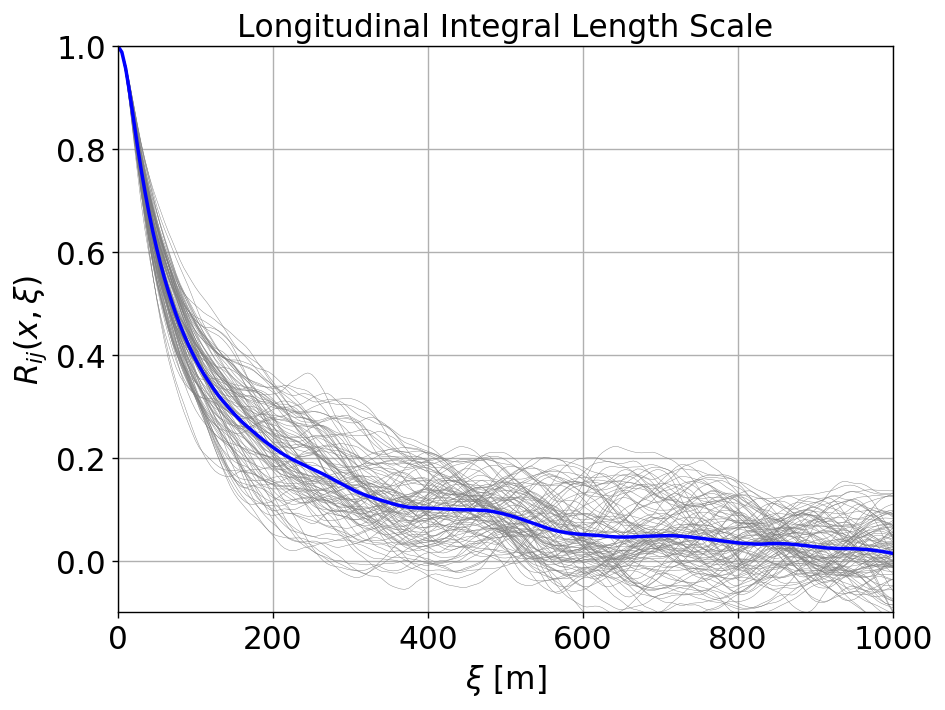

In [ ]:
# Plot the LONG Rij
plt.figure(figsize=(8,6), dpi=125)
#plt.rc('font', size=14)


for ir, Rij in  enumerate(allRij[:Nlong]):
    plt.plot(allf[Nlong], Rij, 'gray', lw=0.25)
# Average
fsize=18
plt.plot(allf[Nlong], avgRijLong, 'b', lw=2)
plt.ylim([-0.1, 1])
plt.xlim([0, probelength])
plt.grid()
plt.xlabel(r'$\xi$ [m]',fontsize=fsize)
plt.title("Longitudinal Integral Length Scale",fontsize=fsize)
plt.ylabel(r'$R_{ij}(x,\xi)$',fontsize=fsize)
plt.tick_params(axis='both', which='major', labelsize=fsize)  # Major ticks
plt.tick_params(axis='both', which='minor', labelsize=fsize)  # Minor ticks (if any)
plt.savefig('./figures/ABL_integral_lengthscale_long.png')

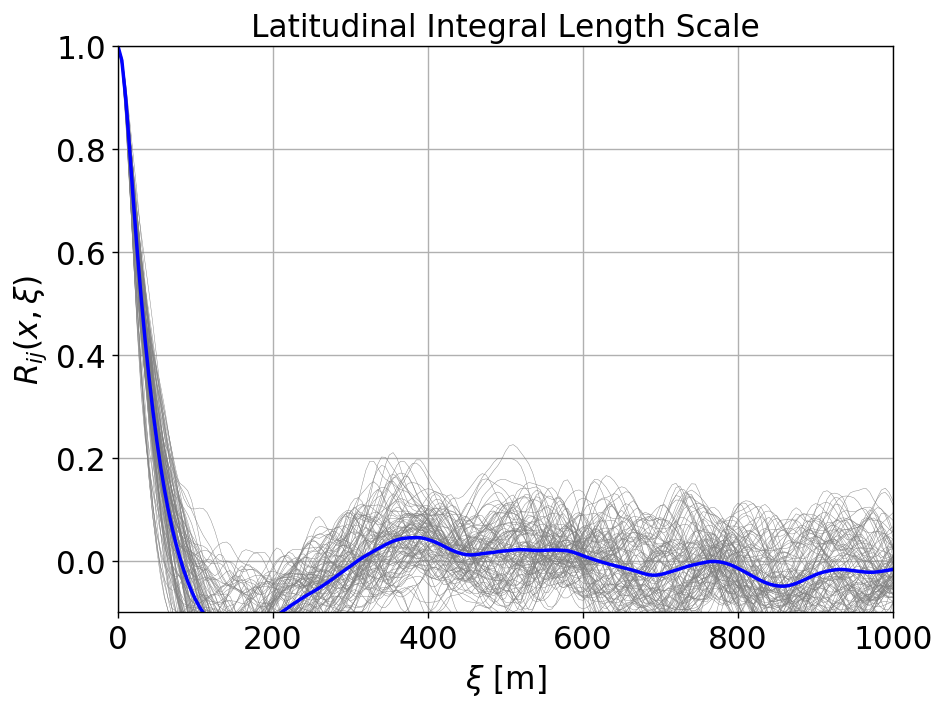

In [ ]:
# Plot the LAT Rij
plt.figure(figsize=(8,6), dpi=125)
#plt.rc('font', size=14)
fsize = 18

for ir, Rij in  enumerate(allRij[Nlong:]):
    plt.plot(allf[Nlong], Rij, 'gray', lw=0.25)
# Average
plt.plot(allf[Nlong], avgRijLat, 'b', lw=2)
plt.ylim([-0.1, 1])
plt.xlim([0, probelength])
plt.grid()
plt.xlabel(r'$\xi$ [m]',fontsize=fsize)
plt.title("Latitudinal Integral Length Scale",fontsize=fsize)
plt.ylabel(r'$R_{ij}(x,\xi)$',fontsize=fsize)
plt.tick_params(axis='both', which='major', labelsize=fsize)  # Major ticks
plt.tick_params(axis='both', which='minor', labelsize=fsize)  # Minor ticks (if any)
plt.savefig('./figures/ABL_integral_lengthscale_lat.png')


In [47]:
# Calculate lengthscale
lengthscale = corr.calclengthscale(allf[0], avgRijLong-0.0,max=1000)
print('LONG lengthscale = %f'%lengthscale)
lengthscale = corr.calclengthscale(allf[Nlong], avgRijLat)
print('LAT lengthscale  = %f'%lengthscale)

LONG lengthscale = 154.937507
LAT lengthscale  = 34.032904
